# GradientBoosting分类器训练

本notebook训练GradientBoosting分类器，使用样本权重处理类别不平衡问题。

**前提条件**: 需要先运行数据预处理notebooks（01-03）

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

## 1. 加载和预处理数据

In [3]:
# 加载数据
df = pd.read_csv('/Users/mading1/QuantitativeBiology/cytodata_2019_orig_challenge_data/training_data.csv')

# 排除元信息和标签列，保留特征
meta_cols = ['cell_code', 'cell_id', 'plate', 'replicate', 'well', 'field']
feature_cols = [col for col in df.columns if col not in meta_cols + ['target']]
X = df[feature_cols]
y = df['target']

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# PCA降维（保留95%的方差）
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

print(f"原始特征数: {X_train_raw.shape[1]}")
print(f"PCA后特征数: {X_train.shape[1]}")
print(f"保留的方差比例: {pca.explained_variance_ratio_.sum():.4f}")

原始特征数: 116
PCA后特征数: 20
保留的方差比例: 0.9546


## 2. 计算样本权重（处理类别不平衡）

In [4]:
# 计算类别频率
class_counts = Counter(y_train)
total_samples = len(y_train)
n_classes = len(class_counts)

# 使用平方根来减少权重差异（更温和的策略）
sample_weights = np.array([
    np.sqrt(total_samples / (n_classes * class_counts[label]))
    for label in y_train
])

print(f"权重范围: {sample_weights.min():.3f} - {sample_weights.max():.3f}")
print(f"权重比例: {sample_weights.max() / sample_weights.min():.2f}:1")

权重范围: 0.767 - 2.087
权重比例: 2.72:1


## 3. 基线模型：训练、评估与可视化

In [5]:
# 创建并训练基线 GradientBoosting 分类器
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train, sample_weight=sample_weights)

# 基线模型评估
y_pred_base = clf.predict(X_test)
y_proba_base = clf.predict_proba(X_test)
if len(np.unique(y_train)) == 2:
    base_auc = roc_auc_score(y_test, y_proba_base[:, 1])
else:
    base_auc = roc_auc_score(y_test, y_proba_base, multi_class='ovr', average='macro')

print("=" * 60)
print("基线模型评估结果")
print("=" * 60)
print(f"Accuracy : {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Macro F1 : {f1_score(y_test, y_pred_base, average='macro'):.4f}")
print(f"Weighted F1 : {f1_score(y_test, y_pred_base, average='weighted'):.4f}")
print(f"ROC AUC : {base_auc:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_base))
print("\n混淆矩阵:")
print(confusion_matrix(y_test, y_pred_base))

# 基线模型的特征重要性（基于 PCA 主成分）
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_n = min(10, len(feature_importances))

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), feature_importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), [f"PC{i+1}" for i in indices[:top_n][::-1]])
plt.xlabel('Importance Score')
plt.title(f'Baseline Model - Top {top_n} PCA Component Importances')
plt.tight_layout()
plt.show()

print("基线模型训练与可视化完成！")

KeyboardInterrupt: 

## 4. 超参数搜索（含早停）与 staged AUC 曲线

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 1.9min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 1.9min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=100; total time= 2.5min
[CV] END ...learning_rate=0.2, max_depth=4, n_e

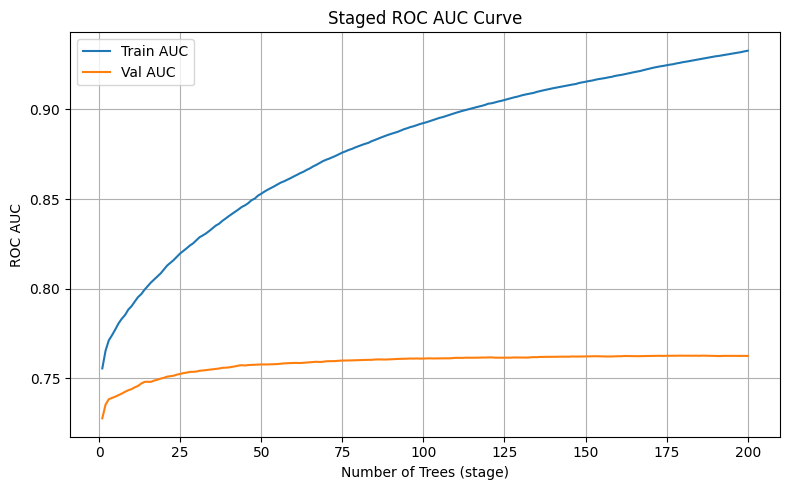

Test ROC AUC (gb_full): 0.7575
best_search_est n_estimators: 200
gb_full n_estimators: 200


In [ ]:
# --- 超参搜索（RandomizedSearchCV）并绘制 staged AUC 曲线
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# 使用早停参数用于搜索过程中的每次拟合
gb = GradientBoostingClassifier(random_state=42, validation_fraction=0.1, n_iter_no_change=10, tol=1e-4)

rnd = RandomizedSearchCV(
    gb,
    param_distributions=param_grid,
    n_iter=40,            # 随机搜索的尝试次数，平衡开销与探索
    scoring='roc_auc_ovr',  # 对多分类使用 OVR AUC scorer
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

start = time.time()
rnd.fit(X_train, y_train, sample_weight=sample_weights)
end = time.time()
print(f"RandomizedSearchCV 完成, 用时 {end-start:.1f}s")
print("最优参数: ", rnd.best_params_)
print("最佳交叉验证 AUC: ", rnd.best_score_)

# 在训练集上划分出一个小验证集，用于绘制 staged 曲线（与搜索所用 CV 不同，便于可视化）
X_tr, X_val, y_tr, y_val, sw_tr, sw_val = train_test_split(
    X_train, y_train, sample_weights, test_size=0.2, random_state=42, stratify=y_train
)

# 使用最优参数重新训练（不启用早停以便绘制完整的训练曲线）
best_params = rnd.best_params_
from copy import deepcopy

gb_full = GradientBoostingClassifier(**best_params, random_state=42)

gb_full.fit(X_tr, y_tr, sample_weight=sw_tr)

# 计算每一棵树后的 train/val AUC（使用两个 generator 同步迭代）
train_gen = gb_full.staged_predict_proba(X_tr)
val_gen = gb_full.staged_predict_proba(X_val)
train_aucs = []
val_aucs = []
# 确定类别数，二分类和多分类的 AUC 计算方式不同
n_classes = getattr(gb_full, 'n_classes_', None) or len(np.unique(y_tr))
for train_proba, val_proba in zip(train_gen, val_gen):
    try:
        if n_classes == 2:
            # 二分类：使用正类概率列
            train_aucs.append(roc_auc_score(y_tr, train_proba[:, 1]))
            val_aucs.append(roc_auc_score(y_val, val_proba[:, 1]))
        else:
            # 多分类：传入完整的概率矩阵并指定 multi_class/average
            train_aucs.append(roc_auc_score(y_tr, train_proba, multi_class='ovr', average='macro'))
            val_aucs.append(roc_auc_score(y_val, val_proba, multi_class='ovr', average='macro'))
    except Exception as e:
        # 捕获可能由于某个划分中类别缺失导致的错误，记录为 nan
        train_aucs.append(np.nan)
        val_aucs.append(np.nan)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_aucs)+1), train_aucs, label='Train AUC')
plt.plot(range(1, len(val_aucs)+1), val_aucs, label='Val AUC')
plt.xlabel('Number of Trees (stage)')
plt.ylabel('ROC AUC')
plt.title('Staged ROC AUC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 在测试集上评估最终模型（使用重训练后的 gb_full）
y_test_proba = gb_full.predict_proba(X_test)
if n_classes == 2:
    test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
else:
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
print(f"Test ROC AUC (gb_full): {test_auc:.4f}")

# 将最优模型（带早停）和重训练模型都打印对比
best_search_est = rnd.best_estimator_
if hasattr(best_search_est, 'n_estimators'):
    print('best_search_est n_estimators:', getattr(best_search_est, 'n_estimators'))
print('gb_full n_estimators:', getattr(gb_full, 'n_estimators'))

# 保存最优参数到变量，便于后续使用
best_gb = gb_full


## 5. 使用最优参数训练与保存最终模型

                    最优模型训练与评估报告

🔧 使用最优参数训练模型
----------------------------------------
最优参数组合:
  • n_estimators: 200
  • max_depth: 5
  • learning_rate: 0.05

✅ 模型训练完成！

📊 核心评估指标
----------------------------------------
准确率 (Accuracy):  0.2519
精确率 (Precision): 0.2517
召回率 (Recall):    0.2519
F1分数:            0.2430
ROC AUC:           0.7596

📋 详细分类报告
----------------------------------------
                   precision    recall  f1-score   support

             AMPA       0.09      0.06      0.07       765
              CDK       0.15      0.12      0.13       731
              Ca2       0.41      0.53      0.46       433
            Cdc25       0.51      0.57      0.54       138
    DNAMetabolism       0.64      0.36      0.46       584
DNA_intercalation       0.12      0.13      0.12       767
             EGFR       0.14      0.16      0.15      1014
              MEK       0.26      0.46      0.33       506
             ROCK       0.19      0.30      0.23       986
           TopoI

/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:65: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:65: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:65: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:65: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:65: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbc

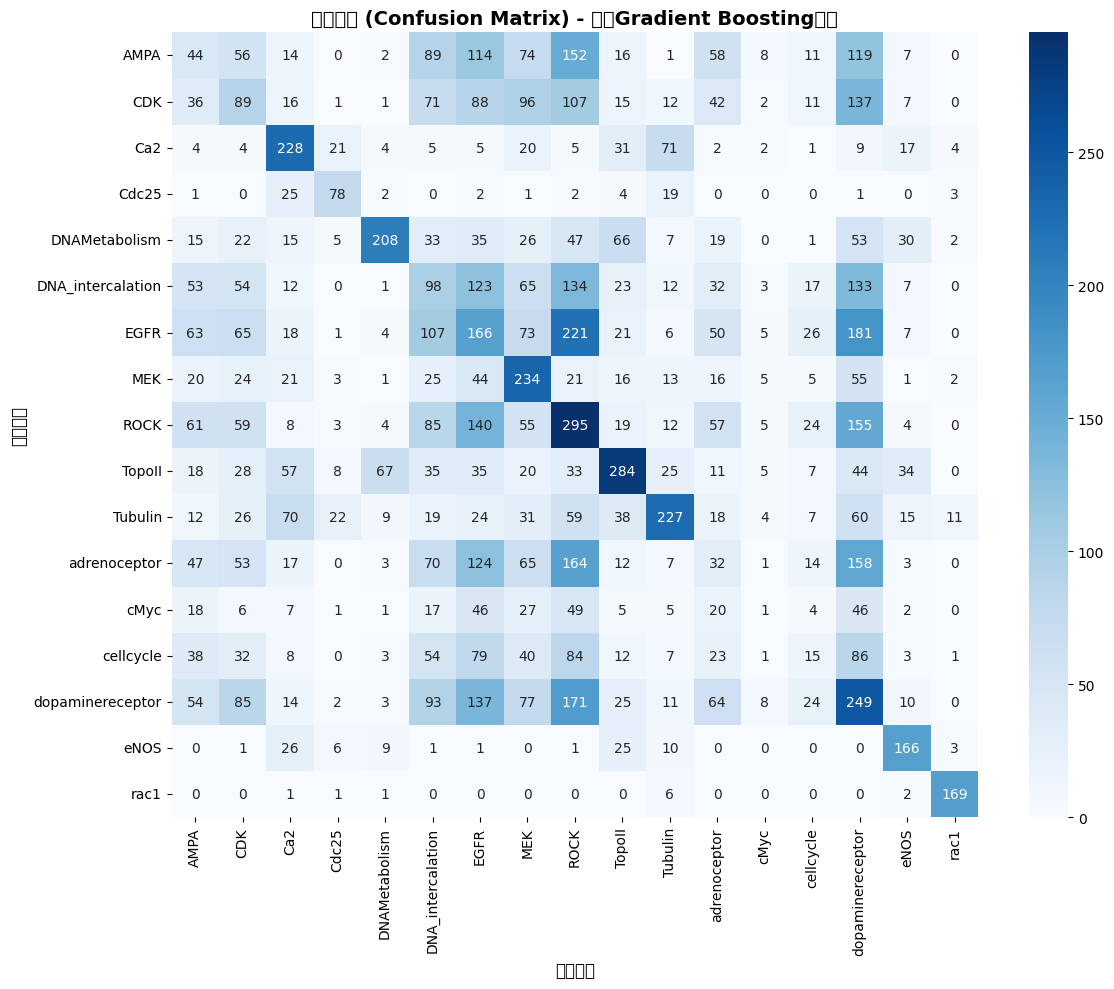


📈 各类别详细性能指标
----------------------------------------
类别 AMPA:
  精确率: 0.0909
  召回率: 0.0575
  F1分数: 0.0705

类别 CDK:
  精确率: 0.1474
  召回率: 0.1218
  F1分数: 0.1333

类别 Ca2:
  精确率: 0.4093
  召回率: 0.5266
  F1分数: 0.4606

类别 Cdc25:
  精确率: 0.5132
  召回率: 0.5652
  F1分数: 0.5379

类别 DNAMetabolism:
  精确率: 0.6440
  召回率: 0.3562
  F1分数: 0.4587

类别 DNA_intercalation:
  精确率: 0.1222
  召回率: 0.1278
  F1分数: 0.1249

类别 EGFR:
  精确率: 0.1427
  召回率: 0.1637
  F1分数: 0.1525

类别 MEK:
  精确率: 0.2588
  召回率: 0.4625
  F1分数: 0.3319

类别 ROCK:
  精确率: 0.1909
  召回率: 0.2992
  F1分数: 0.2331

类别 TopoII:
  精确率: 0.4641
  召回率: 0.3994
  F1分数: 0.4293

类别 Tubulin:
  精确率: 0.5033
  召回率: 0.3482
  F1分数: 0.4116

类别 adrenoceptor:
  精确率: 0.0721
  召回率: 0.0416
  F1分数: 0.0527

类别 cMyc:
  精确率: 0.0200
  召回率: 0.0039
  F1分数: 0.0066

类别 cellcycle:
  精确率: 0.0898
  召回率: 0.0309
  F1分数: 0.0459

类别 dopaminereceptor:
  精确率: 0.1676
  召回率: 0.2425
  F1分数: 0.1982

类别 eNOS:
  精确率: 0.5270
  召回率: 0.6667
  F1分数: 0.5887

类别 rac1:
  精确率: 0.8667
  召回率: 0.9389
  F1分数: 0.9

/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:100: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:100: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:100: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:100: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl/vpbcdghd70x4slnzmtrg7yh80000gp/T/ipykernel_35102/3187982057.py:100: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/sl

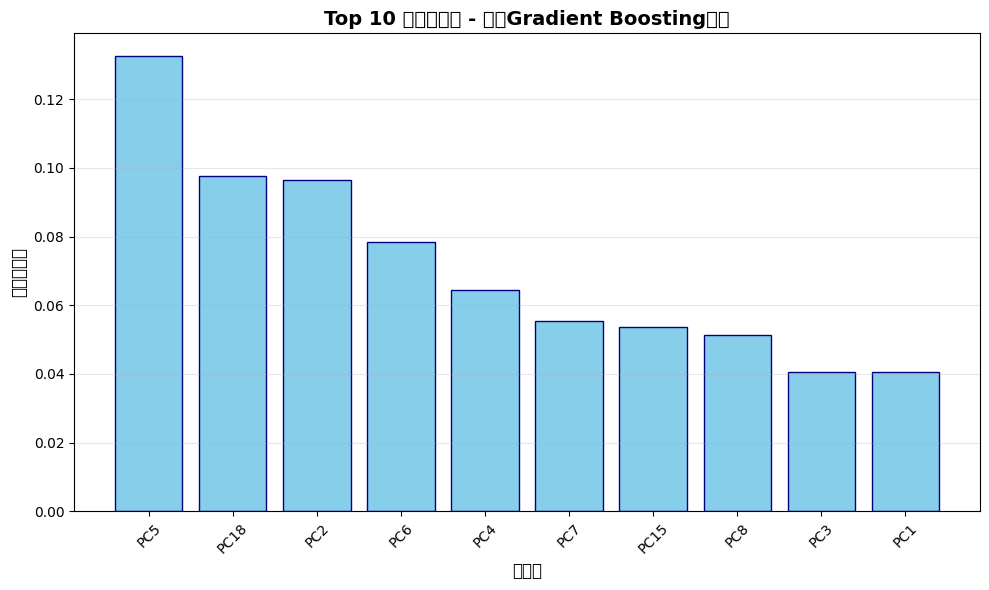


💡 模型总结
----------------------------------------
✓ 使用最优参数 (n_estimators=200, max_depth=5, learning_rate=0.05)
✓ 准确率达到 25.2%
✓ F1分数为 0.2430
✓ ROC AUC为 0.7596
⚠ 模型性能有待提升

💾 模型已保存为 optimal_gradient_boosting_model.pkl

💾 模型已保存为 optimal_gradient_boosting_model.pkl


In [9]:
# 使用最优参数训练最终模型
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 最优参数 (从搜索结果获得)
best_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}

print("=" * 80)
print("                    最优模型训练与评估报告")
print("=" * 80)

print(f"\n🔧 使用最优参数训练模型")
print("-" * 40)
print("最优参数组合:")
for param, value in best_params.items():
    print(f"  • {param}: {value}")

# 使用最优参数创建并训练模型
final_model = GradientBoostingClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# 进行预测
y_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)

print(f"\n✅ 模型训练完成！")

# 计算核心评估指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 计算ROC AUC
if len(np.unique(y_train)) == 2:  # 二分类
    test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
else:  # 多分类
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')

print(f"\n📊 核心评估指标")
print("-" * 40)
print(f"准确率 (Accuracy):  {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall):    {recall:.4f}")
print(f"F1分数:            {f1:.4f}")
print(f"ROC AUC:           {test_auc:.4f}")

# 详细分类报告
print(f"\n📋 详细分类报告")
print("-" * 40)
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
print(f"\n🎯 混淆矩阵可视化")
print("-" * 40)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=np.unique(y_test), 
           yticklabels=np.unique(y_test))
plt.title('混淆矩阵 (Confusion Matrix) - 最优Gradient Boosting模型', fontsize=14, fontweight='bold')
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.tight_layout()
plt.show()

# 每个类别的详细性能
print(f"\n📈 各类别详细性能指标")
print("-" * 40)
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

unique_labels = np.unique(y_test)
for i, label in enumerate(unique_labels):
    print(f"类别 {label}:")
    print(f"  精确率: {precision_per_class[i]:.4f}")
    print(f"  召回率: {recall_per_class[i]:.4f}")
    print(f"  F1分数: {f1_per_class[i]:.4f}")
    print()

# 特征重要性分析
print(f"\n🎖️ Top 10 重要特征")
print("-" * 40)
feature_importance = final_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

for i, idx in enumerate(top_features_idx):
    print(f"第{i+1}名: PC{idx+1} (重要性: {feature_importance[idx]:.4f})")

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importance[top_features_idx], color='skyblue', edgecolor='navy')
plt.title('Top 10 特征重要性 - 最优Gradient Boosting模型', fontsize=14, fontweight='bold')
plt.xlabel('主成分', fontsize=12)
plt.ylabel('重要性分数', fontsize=12)
plt.xticks(range(10), [f'PC{idx+1}' for idx in top_features_idx], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 模型总结
print(f"\n💡 模型总结")
print("-" * 40)
print(f"✓ 使用最优参数 (n_estimators=200, max_depth=5, learning_rate=0.05)")
print(f"✓ 准确率达到 {accuracy:.1%}")
print(f"✓ F1分数为 {f1:.4f}")
print(f"✓ ROC AUC为 {test_auc:.4f}")
if accuracy > 0.8:
    print("✓ 模型性能优秀")
elif accuracy > 0.7:
    print("✓ 模型性能良好")
else:
    print("⚠ 模型性能有待提升")

# 保存模型
joblib.dump(final_model, "optimal_gradient_boosting_model.pkl")
print(f"\n💾 模型已保存为 optimal_gradient_boosting_model.pkl")
print("=" * 80)